# Part 2: Modelling


**Author**: Lee Pham

**Date**: November 1st, 2022

**Project**: BrainStation Data Science Bootcamp Capstone Project

## Table of Contents
1. [Introduction](#p1)


2. [Training and Testing Datasets](#p2)


3. [Scaling](#p3)
    

4. [Logistic Regression Classifier](#p4)

    4.1 [Baseline Model](#p4.1)
    
    4.2 [Identify Relevant Features](#p4.2)
    
    4.3 [Tuning Hyperparameters](#4.3) 
    

5. [Non-Linear Machine Learning Models](#p5)

    5.1 [Non-Linear Support Vector Machines Classifier](#p5.1)
    
    5.2 [K-Nearest Neighbors Classifier](#p5.2)
    
    5.3 [Decision Tree Classifier](#p5.3)   
    
    
6. [Conclusion](#p6)

## 1. Introduction <a class= "anchor" id="p1"></a>

The aim of this notebook is to create a machine learning algorithms that can accurately predict instances of an accidents involving cyclists based on a list of input factors. The main purpose behind the the prediction is to be able to identify major threats that cyclists may face in the traffic in order to make recommendations for safer travelling. 

The machine learning algorithms will be created in the following three main processes: 
1. Use a logistic regression classifier to select relevant features with high predictive power. 
2. Use the selected features to build various linear and non-linear machine learning models. 
3. Improve the model's performance by using bagging techniques. 

A target machine learning model for this project will be one that is both explanable and have a high level of precision. The model's level of precision will be measured by the F1 harmony score which shows the balance between the model's precision and recall scores. A model with a high harmony score means that the model does not make too few predictions for the accidents that involve cyclists while the accuracy of the predictions compared to the actual labels of the accident.  

#### Process Overview
The machine learning algorithms will be trained and tested by using the cleaned dataset storing information about records of people who were involved in traffic accidents in the city of Toronto which was produced by the prior Notebook 1. Firstly, the dataset is going to be splitted into a testing and training dataset. After splitting, the datasets will be scaled so that it can be use to train models which are sensitive to scaling such as a logistic regression classifier, K-nearest neighbours classifier, and support vector machines. Since the project is aiming for an explanable model, dimensionality reduction will not be applied to the dataset. As mentioned before, logistic regression models will be used first to explore the predictive power of the features in order to identify the most relevant features. Secondly, several non-linear machine learning models will be trained to find the model which have the highest precision in predicting instances where a cyclist is involved in traffic accidents. Last but not least, a cross validation grid search method or bagging techniques will be applied to the models with the purpose of enhancing the model's level of generalization and accuracies. 

#### Importing Packages
The codes in the cells below will import the packages to process, visualize, transform the datasets, and build the machine learning models. All machine learning models in this notebook will be created by using the Scikit-Learn library. 

In [1]:
# Import packages for processing and visualizing data 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Import packages from Scikit-Learn to build machine learning models 
# Splitting training and testing datasets: 
from sklearn.model_selection import train_test_split
# Scalers:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Pipeline: 
from sklearn.pipeline import Pipeline
# Grid Search CV: 
from sklearn.model_selection import GridSearchCV
# Logistic Regression Classifier: 
from sklearn.linear_model import LogisticRegression
# Decision Tree Classifier:
from sklearn.tree import DecisionTreeClassifier
# KNN Classifier: 
from sklearn.neighbors import KNeighborsClassifier
# Linear Support Vector Machines:
from sklearn.svm import LinearSVC
# Non-Linear Support Vector Machines:
from sklearn.svm import SVC
# Random Forest Classifier:
from sklearn.ensemble import RandomForestClassifier
# Import precision score metric:
from sklearn.metrics import precision_score
# Import recall score metric: 
from sklearn.metrics import recall_score
# Import f1 score metric: 
from sklearn.metrics import f1_score
# Import the confusion matrix plot: 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#### Scoring Function  
The main valuation metrics used in this notebook are the model's training score, testing score, precision score, recall score, and F1 score. The function below will be used to calculate, display and store the evaluations of each machine learning model created throughout the process. 

In [3]:
# Create a function to score the model 
def score_model(model, name, X_train, y_train, X_test, y_test):
    # Input parameters for the function is the name of the model, name of training and testing datasets  
    # 1 - Calculate the training score 
    train_score = model.score(X_train, y_train)
    # 2 - Calculate the testing score 
    test_score = model.score(X_test, y_test)
    # 3 - Make categorical predictions based on the testing dataset and store the predictions in a variable for scoring purposes
    y_pred = model.predict(X_test)
    # 4 - Calculate the precision score of the model 
    ## Set the zero division parameter to turn a precision score of 0 when the model does not predict any instances of a positive class
    precision = precision_score(y_test, y_pred, zero_division=0)
    # 5 - Calculate the recall score of the model
    ## Set the zero division parameter to turn a recall score of 0 when the model does not predict any instances of a positive class
    recall = recall_score(y_test, y_pred, zero_division=0)
    # 6 - Calculate the f1 score of the model 
    ## Set the zero division parameter to turn a F1 score of 0 when the model does not predict any instances of a positive class
    f1 = f1_score(y_test, y_pred, zero_division=0)
    # 7 - Create a dataframe to store the scores 
    score_names = ['Train Score', 'Test Score', 'Precision', 'Recall', 'F1']
    score_num = np.array([train_score,test_score,precision,recall,f1])
    results = pd.DataFrame(score_num.round(4), index=score_names,columns=[f"{name} Model"])
    return results

## 2. Training and Testing Datasets <a class= "anchor" id="p2"></a>

The cleaned dataset will be split into a training and testing dataset before scaling the data or training any models in order to avoid data leakage from the testing dataset. Data leakage is a serious problem which is going to undermine the machine learning model's accuracies level and produce an overfitting model. 

In [4]:
# Upload the cleaned dataset 
df = pd.read_csv("cleaned.csv")
# Drop unnamed column 
df = df.drop(columns=['Unnamed: 0'])

Firstly, the dataset is splitted into a dependent variable column which is a binary column that identify instances of a traffic accident which involve a cyclist. This column will be used by the machine learning models to classify the positive and negative classes. The rest of the columns in the dataset are the independent variables which will be used to make predictions. 

In [5]:
# Create a dataframe which only contain the independent variables 
X_df = df.drop(columns=['inv_cyclist'])

# Identify the X and y variables 
X = X_df.values
y = df['inv_cyclist'].values

In [6]:
# Store the names of the features as a list of strings
features = X_df.columns

Since the instances where a cyclist was involved in a traffic accident only made up of 10.6% of the records in the dataset, a stratify parameter will be applied in the train and test dataset split. The stratify parameter serves to ensure that the records of accidents involving cyclists, or the positive class, are evenly distributed in both training and testing dataset. The size of the test set will be 25% of the original dataset. 

In [7]:
# Split the data into a testing and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

## 3. Scaling <a class= "anchor" id="p3"></a>

The set of independent variables in both training and testing datasets will be transformed by using a scaler to enhance the performance of models which are sensitive to scaling. Since there are various variables in the dataset with differing scales, models such as a logistic regression classifier, k-nearest neighbours classifier, and support vector machines may not be able to accurately interpret how changing the magnitude of one variable will affect another variable. For example, the lattitude, longitude, and total precipitation features uses different scales where the change in 1 degree in the lattitude or longitude is not the same as changing the precipitation by 1 millimeter. 

Since a large portion of features in the dataset are binary columns, a Min Max scaler will be used to transform the dataset instead of a Standard Scaler. The Min Max scaler is more suitable for the data because it does not use positive and negative values to represent the positive and negative classes in the binary columns. 

In [8]:
# Scale the data by using the MinMax scaler 
# 1 - Create scaler 
minmax_scaler = MinMaxScaler()
# 2 - Fit scaler to training data 
minmax_scaler.fit(X_train)

# 3 - Transform the training data by using the scaler
X_train_scaled = minmax_scaler.transform(X_train)

# 4 - Transform the testing data by using the scaler
X_test_scaled = minmax_scaler.transform(X_test)

## 4. Logistic Regression Classifier <a class= "anchor" id="p4"></a>

A logistic regression classifier is a linear model which uses a Sigmoid function to make predictions for both the class label (whether a person was involved in a traffic accident with a cyclist or not) and the probability of the event of getting involved with a cyclist in a traffic accident. A logistic regression's function works by taking in the independent variables, calculate their weights in predicting the outcomes, and combine all the weights of each feature to produce the probability of a record belonging to the positive class. In this case, the logistic regression will take in information about the traffic accidents provided by the independent variables (i.e. the date, time, location, number of people involved, etc.), calculate the weight of these variables, then multiply each variable's input value by their weight and add them together to find the probability of involving a cyclist. The closer the output probability is to one, the higher the chances of the accident involve a cyclist. These weights calculated by the logistic regression are called coefficients which determine the level of influence the variable has on the predicted outcome.   

Thus, the logistic regression classifier is a highly explanable model which can help to identify relevant features and remove irrelevant features. The removal of features with a low level of relevancy can enhance the efficiency of machine learning models. On the other hand, a major disadvantage that the logistic regression model have is it performs better with normal distributions. Thereby, skewness in the data may affect the model's ability to make accurate predictions.

In this project, the logistic regression classifier will be utilize for further exploration of the processed data to gain a better understanding of the features influence on explaining instances of an accident involving cyclists. The feature exploration will be carried out in three steps. Firstly, a baseline model is going to be built find the model's initial level of accuracies when given all features. Secondly, several logistic regression models will be built by using different group of features to identify the features with strong and weak predictive power. Thirdly, the hyperparameters of the logistic regression will be tuned to further explore how changing the way the weights of the input features are calculated can improve the model's accuracies.  

### 4.1 Baseline Model <a class= "anchor" id="p4.1"></a>

The baseline logistic regression model will be trained by using all features in the processed dataset. The hyperparameters for the model is set at default with a maximum of 10,000 iterations. The hyperparameters' default settings are: 
- Default penalty is a L2 Ridge Regression function which uses the sum of the squares of the parameters to shrink the coordinates and ensure that the weight of all features are uniform. 
- Level of regularization (C) is 1.0, meaning that the level of regularization is not strong. 
- Default solver is 'lbfgs' which uses the L2 penalty. 

More information regarding the logistic regression classifier's hyperparameters can be find on the Scikit-Learn website's [link here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [9]:
# Create and fit the baseline logistic regression model without any hyperparameters
logit_base = LogisticRegression(max_iter=10000).fit(X_train_scaled, y_train)

In [10]:
# Score the model by using the score model function 
logit_base_results = score_model(logit_base, 'logit_base' ,X_train_scaled, y_train, X_test_scaled, y_test)

In [11]:
# View the results 
logit_base_results

,logit_base Model
Train Score,0.9189
Test Score,0.9155
Precision,0.6519
Recall,0.4292
F1,0.5176


The results table for the baseline logistic regression model shows that the baseline logistic model is robust as the train and test scores are both 0.91. However, the model's precision score is 0.65 which suggests that out of all predictions for the positive class that the model made, only 65% of them actually involve a cyclists.

The table below shows the coefficient for the model's features. The coefficients for the features measure the strength of the features in predicting whether someone was involved in an accident with a cyclist or not. The larger the coefficient is, the higher the predictive power of the feature in predicting an accident involving cyclists. Features with negative coefficient values suggests that the feature is a good indicator to predict instances of accidents that does not involve cyclists. On the other hand, features with a coefficient value closes to zero show that those features have relatively low predictive power when predicting instances of an accident involving cyclists. 

In [12]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': features, 'Coefficient': logit_base.coef_[0]}
logitb_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logitb_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
17,loc_Toronto and East York,1.306323
51,cau_failed_to_yield_row,1.111726
32,loc_bloor,0.663120
24,loc_dundas,0.662528
49,cau_inattentive,0.637328
3,date_month,0.587926
14,loc_longitude,0.565566
16,loc_Scarborough,0.542139
15,loc_North York,0.469697
1,date_year,0.415865


The bar chart below shows the top 5 features with the highest coefficient values when predicting the positive and negative class label. A positive class label refers to the instances when a cyclist was involved. In contrary, a negative class label refers to the instances when a cyclist was not involved. 

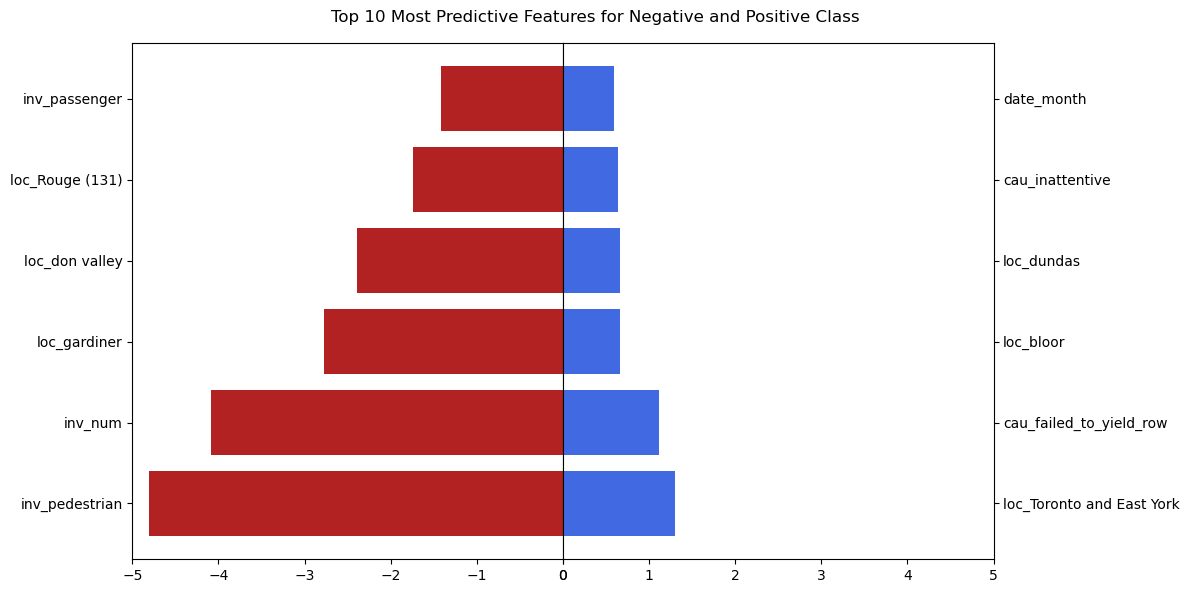

In [13]:
# Plot 2 graphs to show the top 10 most predictive words for both positive and negative reviews 
# Create 2 subplots 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False,figsize=(12, 6))
plt.suptitle("Top 10 Most Predictive Features for Negative and Positive Class")
# Plot the bar chart to show the top 5 most predictive features in predicting accidents involve cyclists
ax2.barh(logitb_coef.sort_values(by='Coefficient', ascending=False)[:6]['Feature_Name'],logitb_coef.sort_values(by='Coefficient', ascending=False)[:6]['Coefficient'], color='royalblue')
ax2.yaxis.tick_right()
ax2.set_xlim(left=0, right=5)
# Plot the bar chart to show the top 5 most predictive features in predicting accidents that does not involve cyclists
ax1.barh(logitb_coef.sort_values(by='Coefficient')[:6]['Feature_Name'], logitb_coef.sort_values(by='Coefficient')[:6]['Coefficient'], color='firebrick')
ax1.set_xlim(left=-5,right=0)
# Format and label the graph
fig.tight_layout()
ax2.yaxis.tick_right()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The features which have the highest predictive power for the positive class are: locational and human factor features. Especially, accidents involving cyclists are predicted to be more likely to happen at the Toronto and East York district, on Bloor or Dundas street. Whether someone failed to yield to right of way is also a highly predictive feature in predicting a cyclist involvement in traffic accidents. In addition, the month feature also have a high predictive power which suggests that seasonality also play a role in predicting accidents involving cyclists. 

On the other hand, the locaitonal and involver groups of features have relatively strong predictive power in predicting instances of traffic accidents which do not involve cyclists. As shown by the red bars on the chart, accidents involving cyclists and other vehicle passengers are unlikely to involve pedestrians as well. In addition, the higher the number of people involved in the traffic accident, the less likely that a cyclist will be involved. As for the locational features, accidents involving cyclists are less likely to occur on Gardiner Expressway, Don Valley, and the Rougue neighbourhood. 

### 4.2 Identifying Relevant Features <a class= "anchor" id="p4.2"></a>

The baseline logistic regression model suggests that locational features are more likely to have high predictive power than other gorup of features. As mentioned in the prior Notebook 1, the processed dataset composed of 5 groups of features: (1) date and time features (date), (2) locational features (loc), (3) environmental features (env), (4) type of involver features (inv), and (5) human factors features (cau). Firstly five logistic regression models will be created by using each group of features to explore each group of features' predictive power. 

#### Model With Time and Date Features

This logistic regression model is created by using only features which contain time and date information regarding the traffic accident. Below is a list of features which belong to the date and time feature group. 

In [14]:
# Retrieve a list of features with the 'date' prefix
datetime_features = [col for col in X_df if col.startswith('date')]
datetime_features

['date_year',
 'date_winter',
 'date_month',
 'date_Monday',
 'date_Saturday',
 'date_Sunday',
 'date_Thursday',
 'date_Tuesday',
 'date_Wednesday',
 'date_morning',
 'date_afternoon',
 'date_evening']

The list of features belonging to the date and time group of features will be used to create a baseline logistic regression model, using default settings for the hyperparameters. 

In [15]:
# Get a list of index for columns with the 'date prefix'
datetime = [X_df.columns.get_loc(datetime_features[i]) for i in range(len(datetime_features))]

# Filter for the columns that belong to the date and time group 
X_train_date = X_train_scaled[:,datetime]
X_test_date = X_test_scaled[:,datetime]

In [16]:
# Build a logistic regression with the selected features 
logit_base_date = LogisticRegression(max_iter=10000).fit(X_train_date, y_train)

In [17]:
# Score the model by using the score model function 
logit_base_results_date = score_model(logit_base_date, 'logit_base_date' ,X_train_date, y_train, X_test_date, y_test)

After training and testing the model, the results suggest that the logistic regression model did not predict any instances of a traffic accident involving a cyclist. Thus, the results suggest that the model cannot identify any trends regarding the timing of the traffic accidents which are specific to accidents involving cyclists. 

In [18]:
# View the model's scores
logit_base_results_date

,logit_base_date Model
Train Score,0.8945
Test Score,0.8944
Precision,0.0000
Recall,0.0000
F1,0.0000


C:\Users\nghip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


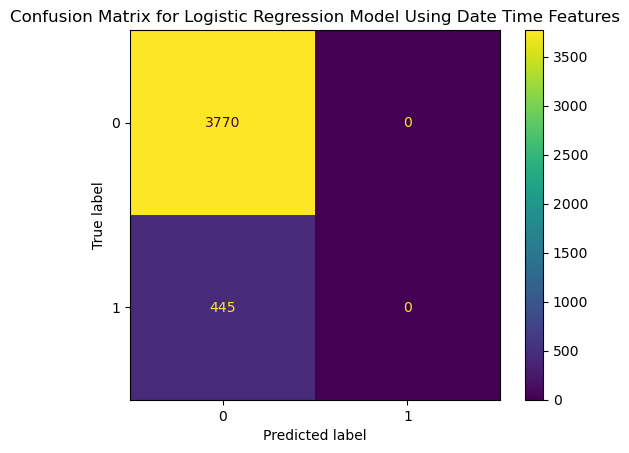

In [19]:
# Plot a confusion matrix to view the portion of false negatives and false positives that the model predicted
plot_confusion_matrix(logit_base_date, X_test_date, y_test)
plt.title('Confusion Matrix for Logistic Regression Model Using Date Time Features')
plt.show()

The confusion matrix plot above shows the number of predictions that the model made for each class compared to the actual labels of the class given by the dependent variable (y). The two zeros in the predicted positive class label (1) indicate that the model predicted that none of the records of traffic accidents involve cyclists. 

In [20]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': datetime_features, 'Coefficient': logit_base_date.coef_[0]}
logit_date_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_date_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
11,date_evening,0.520424
10,date_afternoon,0.431284
2,date_month,0.412560
9,date_morning,0.406507
0,date_year,0.393200
6,date_Thursday,0.320425
7,date_Tuesday,0.152725
3,date_Monday,-0.022066
4,date_Saturday,-0.045009
8,date_Wednesday,-0.069792


Furthermore, the features' coefficients above are close to zero which suggest that the date and time features have weak predictive power when predicting instances of traffic accidents which involve cyclists. Out of these features, the winter feature have the highest absolute coefficient value of 0.99 which shows that cyclists are least likely to get involved in traffic accidents during the winter time. Additionally, the evening time variable also have a relatively high coefficient value of 0.52 which implies that cyclists involving accidents are more likely to happen during the evening time. These subtle trends derived from the features' coefficients are similar to the findings from the previous Notebook 1. 

#### Model With Locational Features 

The logistic regression model below will be created by only using the features which store the accidents' location information. The following list shows the names of the features belong to this group. 

In [21]:
# Retrieve a list of features with the 'loc' prefix
location_features = [col for col in X_df if col.startswith('loc')]
location_features

['loc_latitude',
 'loc_longitude',
 'loc_North York',
 'loc_Scarborough',
 'loc_Toronto and East York',
 'loc_Bay Street Corridor (76)',
 'loc_Rouge (131)',
 'loc_Waterfront Communities-The Island (77)',
 'loc_West Humber-Clairville (1)',
 'loc_Wexford/Maryvale (119)',
 'loc_Woburn (137)',
 'loc_dundas',
 'loc_steeles',
 'loc_finch',
 'loc_lawrence',
 'loc_lake shore',
 'loc_queen',
 'loc_clair',
 'loc_sheppard',
 'loc_bloor',
 'loc_gardiner',
 'loc_victoria',
 'loc_don mills',
 'loc_don valley',
 'loc_king']

Similar to the model in the previous part, this model also uses a default settings for the hyperparameters for consistency purpose. In the cells below, a logistic regression classifier will be created by only using the features storing information about the locations of the traffic accidents. 

In [22]:
# Get a list of index for columns with the 'loc' prefix
location = [X_df.columns.get_loc(location_features[i]) for i in range(len(location_features))]

# Filter for the columns that belong to the group of features containing locational information
X_train_loc = X_train_scaled[:,location]
X_test_loc = X_test_scaled[:,location]

In [23]:
# Build a logistic regression with the selected features 
logit_base_loc = LogisticRegression(max_iter=10000).fit(X_train_loc, y_train)

In [24]:
# Score the model by using the score model function 
logit_base_results_loc = score_model(logit_base_loc, 'logit_base_loc' ,X_train_loc, y_train, X_test_loc, y_test)

The model's performance for the model using locational features is similar to the model using time and date features. According to the score table below, using the locational features alone does not provide the model enough information to distinguish between traffic accidents that involved cyclists and those that did not involve cyclists. Thereby, a recall score of 0 shows that the model did not make any predictions for the positive class.  

In [25]:
# View the model's scores
logit_base_results_loc

,logit_base_loc Model
Train Score,0.8945
Test Score,0.8944
Precision,0.0000
Recall,0.0000
F1,0.0000


Despite the model's poor performance, the table below shows the coefficients for each features which contain the traffic accident's locational information. The features with a large coefficient suggests that accidents involving cyclists are more likely to happen there compared to locations with a low coefficient values. 

In [26]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': location_features, 'Coefficient': logit_base_loc.coef_[0]}
logit_loc_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_loc_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
4,loc_Toronto and East York,0.868200
1,loc_longitude,0.824687
19,loc_bloor,0.455538
11,loc_dundas,0.337553
24,loc_king,0.276725
2,loc_North York,0.218198
3,loc_Scarborough,0.208345
12,loc_steeles,0.112634
5,loc_Bay Street Corridor (76),0.053958
16,loc_queen,-0.015316


Traffic accidents which involve cyclists are least likely to happen on the Gardiner Expressway and Don Valley Parkway. In contrary, the Toronto and East York district is most likely to have a higher number of accidents involving cyclists.  

More importantly, since the logistic regression model is sensitive to multi-collinearity relationships between the features, the relationships between the locations might be a major factor which lead to the model's poor performance. The heatmap below shows the correlation between each variables storing locational information. 

C:\Users\nghip\AppData\Local\Temp\ipykernel_20188\995451369.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))


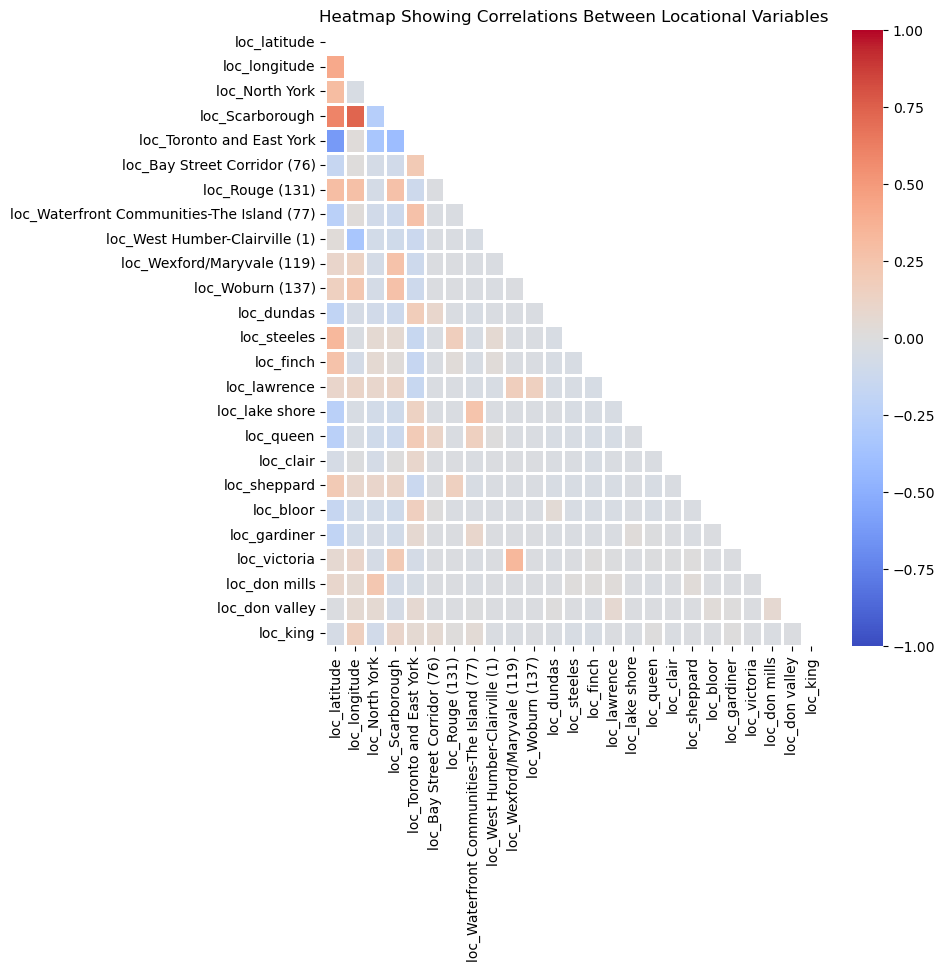

In [27]:
# Plot heat map to show the multi-collinearity relationships between the features 
plt.figure(figsize=(8,8))
df_corr = X_df[location_features].corr().round(2)
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
sns.heatmap(df_corr, cmap='coolwarm', vmax=1, vmin=-1, lw=2, mask=mask)
plt.title('Heatmap Showing Correlations Between Locational Variables')
plt.show()

The pearson correlation tests between each pair of variables in the group of variables containing locational information suggest that there is a moderately strong negative correlation between the lattitude and longitude. In addition, the dummy variables representing the districts such as Scarborough, North York, and Toronto and East York also have a moderate correlation with other variables. Since a district cover a larger area than a neighbourhood or a street so including the district in a logistic regression may cause multi-collinearity relationships and prevent the model from making more percise predictions based on using a road or a neighbourhood alone. Thereby, the dummy variables for the district, latitude and longitude features will also be removed as they have a high correlation with various variables. 

In [28]:
# Get a list of index for the location features, excluding the latitude, longitude, and district variables 
location_features_2 = location_features[5:]
location_2 = [X_df.columns.get_loc(location_features_2[i]) for i in range(len(location_features_2))]

# Filter for the columns that belong to the group of features containing locational information
X_train_loc_2 = X_train_scaled[:,location_2]
X_test_loc_2 = X_test_scaled[:,location_2]

In [29]:
# Build a logistic regression with the selected features 
logit_base_loc_2 = LogisticRegression(max_iter=10000).fit(X_train_loc_2, y_train)

The scores of the logistic regression model for the locational features did not improve after removing features that have multi-collinearity relationships. Although the model is not overfitting or underfitting, it was not able to make any predictions for the instances of accidents that involve cyclists based on the limited amount of input information.  

In [30]:
# Score the model by using the score model function 
logit_base_results_loc_2 = score_model(logit_base_loc_2, 'logit_base_loc_2' ,X_train_loc_2, y_train, X_test_loc_2, y_test)
# View the model's score 
logit_base_results_loc_2 

,logit_base_loc_2 Model
Train Score,0.8945
Test Score,0.8944
Precision,0.0000
Recall,0.0000
F1,0.0000


Upon further inspection, the coefficients value for the street name dummy variables increases or decreases further away from zero after the latitude, longitude, and district dummy variables was removed. As shown by the table below, the coefficient for the Bloor street variable increases to a value of 0.85 which is close to the coefficient of 0.87 for the Toronto and East York district variable. In addition, the coefficient of the features which have the highest predictive power in predicting instances of a negative class where a cyclist is not involved in traffic accidents remain unchanged compared to the previous model. Therefore, the removal of the variables with multi-collinearity relationship suggests that the street name may be a good indicator for predicting accidents involving cyclists.   

In [31]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': location_features_2, 'Coefficient': logit_base_loc_2.coef_[0]}
logit_loc_coef_2 = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_loc_coef_2.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
14,loc_bloor,0.856003
6,loc_dundas,0.779782
0,loc_Bay Street Corridor (76),0.560734
19,loc_king,0.493054
2,loc_Waterfront Communities-The Island (77),0.428644
11,loc_queen,0.388471
16,loc_victoria,-0.160081
12,loc_clair,-0.175493
10,loc_lake shore,-0.300241
4,loc_Wexford/Maryvale (119),-0.711289


#### Model With Environmental Features

The logistic regression model below is trained and tested by using the group of features which only contain the environmental conditions where the traffic accident occurred. For instance, these environmental conditions may be the weather, lighting, or type of road structure at the location of the accident. The list below shows the five features which were added to the cleaned dataset to be used in the modelling process. 

In [32]:
# Retrieve a list of features with the 'env' prefix
env_features = [col for col in X_df if col.startswith('env')]
env_features

['env_no_traffic_control',
 'env_intersection',
 'env_major_arterial',
 'env_daylight',
 'env_precipitation']

In [33]:
# Get a list of index for columns with the 'env' prefix
env = [X_df.columns.get_loc(env_features[i]) for i in range(len(env_features))]

# Filter for the columns that belong to the environmental factors group of features 
X_train_env = X_train_scaled[:,env]
X_test_env = X_test_scaled[:,env]

A logistic regression with a maximum number of 10,000 iterations and default settings for the hyperparameter will be constructed by using the scaled dataset which only contain the features describing the environmental conditions at the time of the accident. 

In [34]:
# Build a logistic regression with the selected features 
logit_base_env = LogisticRegression(max_iter=10000).fit(X_train_env, y_train)

In [35]:
# Score the model by using the score model function 
logit_base_results_env = score_model(logit_base_env, 'logit_base_env' ,X_train_env, y_train, X_test_env, y_test)

Similar to the models created by only using the features describing the time and date, and locational information, this model also perform poorly. As shown by the scoring table below, the model incurred a recall score of 0, meaning that it did not make any predictions for the positive class. Thereby, using the environmental condition features alone is not sufficient for the logistic regression classifier to pick out specific trends and make predictions. 

In [36]:
# View the model's results 
logit_base_results_env

,logit_base_env Model
Train Score,0.8945
Test Score,0.8944
Precision,0.0000
Recall,0.0000
F1,0.0000


Out of the five features storing information regarding the environmental conditions, the additional precipitation feature has the strongest predicting power for the negative class. Hence, the higher the precipitation rate is, the lower the chances of being involved in a traffic accident with a cyclist. Furthermore, the intersection or not traffic control variables have a relatively low predictive power despite how they were a frequently observed trait across a large number of traffic accidents with or without cyclists. 

In [37]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': env_features, 'Coefficient': logit_base_env.coef_[0]}
logit_env_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_env_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
3,env_daylight,0.533222
1,env_intersection,0.281248
0,env_no_traffic_control,0.009582
2,env_major_arterial,-0.325539
4,env_precipitation,-1.537942


The finding that the precipitation rate has a negative correlation to the instances of traffic accidents involving cyclists further support the finding that cyclists are least likely to travel under highly humid weather conditions. 

#### Model With Involver Features

In this part, a logistic regression will be trained and tested by using the features which describe the involvers in the traffic accident. These features contain information regarding the total number of people involved, other types of involver, the injury level, and fatality. The list below shows the names of the features within this group. 

In [38]:
# Retrieve a list of features with the 'inv' prefix
inv_features = [col for col in X_df if col.startswith('inv')]
inv_features

['inv_num',
 'inv_pedestrian',
 'inv_automobile',
 'inv_passenger',
 'inv_injury_level',
 'inv_fatal_acc']

In [39]:
# Get a list of index for columns with the 'inv' prefix
inv = [X_df.columns.get_loc(inv_features[i]) for i in range(len(inv_features))]

# Filter for the columns that belong to the involver features group 
X_train_inv = X_train_scaled[:,inv]
X_test_inv = X_test_scaled[:,inv]

Similarly, a logistic regression with 10,000 maximum number of iterations which use a default settings for the hyperparameter will be created by solely using the chosen group of features.  

In [40]:
# Build a logistic regression with the selected features 
logit_base_inv = LogisticRegression(max_iter=10000).fit(X_train_inv, y_train)

In [41]:
# Score the model by using the score model function 
logit_base_results_inv = score_model(logit_base_inv, 'logit_base_inv' ,X_train_inv, y_train, X_test_inv, y_test)

The resulting model scores suggest that by using the features describing the involvers alone, the logistic regression can start to make some predictions regarding the cyclists involvement. As shown by the precision score below, 46.8% of the model predictions for the cyclist involvement was accurate. 

In [42]:
# View the model's results
logit_base_results_inv

,logit_base_inv Model
Train Score,0.8942
Test Score,0.8932
Precision,0.4675
Recall,0.0809
F1,0.1379


The confusion matrix plot below further shows that the model predicted a high number of true negative cases as there were 406 true negatives found in the bottom left section. On the other hand, the model predicted a relatively low instances of false positive cases as shown by the 41 false positive cases displayed in the plot's top right section. The higher instances of true negative predictions suggest that the model does not have enough information to distinguish more accidents where a cyclist was involved rather than other types of involver. 

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


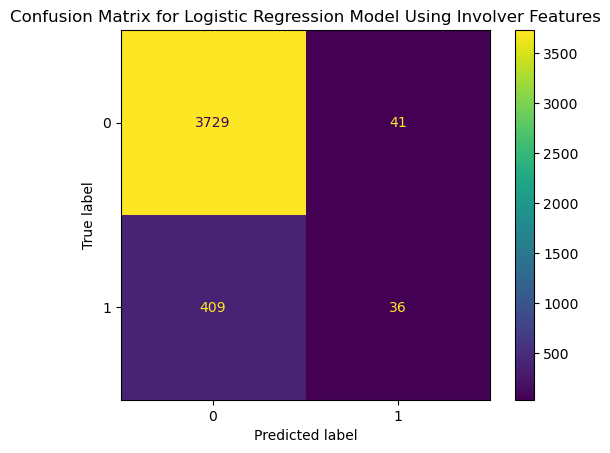

In [43]:
# Plot a confusion matrix to view the portion of false negatives and false positives that the model predicted
plot_confusion_matrix(logit_base_inv, X_test_inv, y_test)
plt.title('Confusion Matrix for Logistic Regression Model Using Involver Features')
plt.show()

The table below shows the coefficients for the features in the model. All features that describe the involvers have negative coefficient values which indicate that they have a negative correlational relationship with the instances of traffic accidents where cyclists were involved. The variable with the lowest coefficient value is the number of involver which implies that the higher the number of involvers are, the lower the chances of the accident involve a cyclist. Additionally, the pedestrian variable also have a low coefficient value which indicate that cyclists are least likely to get involved in traffic accident with pedestrians. 

In [44]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': inv_features, 'Coefficient': logit_base_inv.coef_[0]}
logit_inv_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_inv_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
4,inv_injury_level,-0.652209
5,inv_fatal_acc,-0.662953
2,inv_automobile,-0.924383
3,inv_passenger,-1.516583
1,inv_pedestrian,-4.289380
0,inv_num,-5.056837


Overall, the trends found in the logistic regression model which only use the involver information are very similar to the findings from the early data analysis. The findings regarding the involvers from Notebook 1 also suggest that cyclists are least likely to be involve in accidents with pedestrians. Moreover, cyclists tend to involve in accidents with a fewer number of people than other types of vehicles. 

#### Model With Human Factors Features
The logistic regression model below is created by using the features which describe the human factors that contribute to the cause of the traffic accident. Similar to the features that describe the traffic accidents' involvers, this group of features also refer to the human aspect of the traffic accident. However, this group of features especially focus on the human actions rather than the characteristics. The list below shows the variables which belong to this group. 

In [45]:
# Retrieve a list of features with the 'cau' prefix
cau_features = [col for col in X_df if col.startswith('cau')]
cau_features

['cau_normal',
 'cau_inattentive',
 'cau_driving_properly',
 'cau_failed_to_yield_row',
 'cau_speeding',
 'cau_agressive_driv',
 'cau_going_ahead',
 'cau_turning_left']

In [46]:
# Get a list of index for columns with the 'cau' prefix
cau = [X_df.columns.get_loc(cau_features[i]) for i in range(len(cau_features))]

# Filter for the columns that belong to the human factors features group 
X_train_cau = X_train_scaled[:,cau]
X_test_cau = X_test_scaled[:,cau]

For consistency purposes, the logistic regression model will be created by using a maximum number of 10,000 iterations and default settings for the hyperparameters. 

In [47]:
# Build a logistic regression with the selected features 
logit_base_cau = LogisticRegression(max_iter=10000).fit(X_train_cau, y_train)

In [48]:
# Score the model by using the score model function 
logit_base_results_cau = score_model(logit_base_cau, 'logit_base_cau' ,X_train_cau, y_train, X_test_cau, y_test)

The model's precision, recall, and F1 score of zero shows that by using the features describing the human actions which lead to the accident alone do not provide the model enough information to make predictions for accidents that involve cyclists. Hence, the model's inability to identify the positive class suggests that traffic accidents involving cyclists have a considerable number of similarities to other types of traffic accidents. 

In [49]:
# View the model's scores
logit_base_results_cau

,logit_base_cau Model
Train Score,0.8945
Test Score,0.8944
Precision,0.0000
Recall,0.0000
F1,0.0000


The table showing the coefficient values for the features below suggests that the instances of speeding have the highest predictive power in predicting accidents which do not involve cyclists. A possible explanation for this finding is cyclists are unlikely to be able to bike as fast as other vehicles on the street to exceed the speed limits. On the other hand, a failure to yield to right of way may be a highly predictive feature in predicting the involvement of cyclists in accidents. 

In [50]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': cau_features, 'Coefficient': logit_base_cau.coef_[0]}
logit_cau_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_cau_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
3,cau_failed_to_yield_row,0.831372
6,cau_going_ahead,0.792023
1,cau_inattentive,0.439908
2,cau_driving_properly,0.264672
7,cau_turning_left,0.247507
0,cau_normal,0.210687
5,cau_agressive_driv,-0.648796
4,cau_speeding,-1.227461


#### Model With Selected Features 

After inspecting the models created by using different groups of features, the most predictive features in each group will be selected to create a logistic regression with highly relevant features. This model will be compared to the initial baseline logistic regression model which uses all features. If these two models both achieved similar level of accuracies, the model with fewer features will be selected to enhance the model's computational efficiency and reduce memory usage. 

Firstly, any features with a coefficient value larger than 0.5 or smaller than -0.5 in each group of features will be selected to train a logistic regression which uses a maximum number of 10,000 iterations and a default setting for the hyperparameters. 

In [51]:
# Use list comprehension to retrieve lists of names of features with an absolute coefficient value larger than 0.5 for each group of features 
selected_date = [logit_date_coef['Feature_Name'].iloc[i] for i in range(logit_date_coef.shape[0]) if np.absolute(logit_date_coef['Coefficient'].iloc[i]) > 0.5]
selected_loc = [logit_loc_coef_2['Feature_Name'].iloc[i] for i in range(logit_loc_coef_2.shape[0]) if np.absolute(logit_loc_coef_2['Coefficient'].iloc[i]) > 0.5]
selected_env = [logit_env_coef['Feature_Name'].iloc[i] for i in range(logit_env_coef.shape[0]) if np.absolute(logit_env_coef['Coefficient'].iloc[i]) > 0.5]
selected_inv = [logit_inv_coef['Feature_Name'].iloc[i] for i in range(logit_inv_coef.shape[0]) if np.absolute(logit_inv_coef['Coefficient'].iloc[i]) > 0.5]
selected_cau = [logit_cau_coef['Feature_Name'].iloc[i] for i in range(logit_cau_coef.shape[0]) if np.absolute(logit_cau_coef['Coefficient'].iloc[i]) > 0.5]

# Combine the lists of feature names for each group into a single list 
selected_features = selected_date + selected_loc + selected_env + selected_inv + selected_cau

The list of selected features contain a total of 28 features where a large portion of them belong to the group of features which store locational information. 

In [52]:
# Find the number of features in the list of selected features
len(selected_features)

28

In [53]:
# Retrieve a list of column indexes for the selected features by using a list comprehension
selected_index = [X_df.columns.get_loc(feature) for feature in selected_features]

# Filter for the columns that belong to the selected features group in the scaled datasets
X_train_selected = X_train_scaled[:,selected_index]
X_test_selected = X_test_scaled[:,selected_index]

In [54]:
# Build a logistic regression with the selected features 
logit_base_selected = LogisticRegression(max_iter=10000).fit(X_train_selected, y_train)

In [55]:
# Score the model by using the score model function 
logit_base_results_selected = score_model(logit_base_selected, 'logit_base_selected' ,X_train_selected, y_train, X_test_selected, y_test)

The model created by using the selected features have a higher train score than test score which suggests that the model may be prone to overfitting. Compared to the baseline model, the model with the selected features precision score is 2% lower than the baseline model. The lower precision score maybe due to the model making less predictions for cyclists involvement in accidents as shown by a lower recall score of 0.32 compared to the baseline model's score of 0.43.  

In [56]:
# Compare the model with the selected features' scores to the baseline model 
pd.concat([logit_base_results,logit_base_results_selected], axis=1)

,logit_base Model,logit_base_selected Model
Train Score,0.9189,0.9102
Test Score,0.9155,0.9079
Precision,0.6519,0.6267
Recall,0.4292,0.3169
F1,0.5176,0.4209


The table below shows the coefficient values for the selected features. A majority of the features have a negative coefficients which imply that there are a higher number of indicators in the dataset to identify accidents which do not involve cyclists rather than those that do involve cyclists. Accord to this model, locational information have the highest predictive power in predicting accidents that involve cyclists. Locations such as the Bay Street Corridor neighbourhood, Dundas Street, and Bloor Street are more likely to have traffic accidents involving cyclists than other locations. Additionally, the human action of failing to yield to right of way is also a moderately strong indicator of cyclists being involved in traffic accidents. 

In [57]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': selected_features, 'Coefficient': logit_base_selected.coef_[0]}
logit_selected_coef = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_selected_coef.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
2,loc_Bay Street Corridor (76),1.041663
24,cau_failed_to_yield_row,0.989057
7,loc_dundas,0.987526
12,loc_bloor,0.943791
27,cau_going_ahead,0.486531
1,date_evening,0.274977
16,env_daylight,-0.018299
17,env_precipitation,-0.194431
23,inv_fatal_acc,-0.308063
8,loc_steeles,-0.528290


A second round of feature selection will be carried out to explore how reducing the number of features will influence the model's scores. Thereby, based on the coefficients produced by the previous model which use all features with a coefficient larger than 0.5 or smaller than -0.5, this model will be trained by using the features which have a coefficient with an absolute value larger than 1. The purpose of this following model is to further reduce irrelevant features to the model. 

In [58]:
# Use list comprehension to retrieve lists of names of features with an absolute coefficient value larger than 1 from the list of selected features
selected_features_2 = [logit_selected_coef['Feature_Name'].iloc[i] for i in range(logit_selected_coef.shape[0]) if np.absolute(logit_selected_coef['Coefficient'].iloc[i]) > 1]

The second list of selected features contain 9 features in total. 

In [59]:
# Check for the length of the second list of selected feature names 
len(selected_features_2)

9

In [60]:
# Retrieve a list of column indexes for the selected features by using a list comprehension
selected_index_2 = [X_df.columns.get_loc(feature) for feature in selected_features_2]

# Filter for the columns that belong to the selected features group in the scaled datasets
X_train_selected_2 = X_train_scaled[:,selected_index_2]
X_test_selected_2 = X_test_scaled[:,selected_index_2]

After retrieving the list of indexes for the selected columns based on filtering for features with a coefficient larger than 1, testing and training datasets storing only relevant features is created by indexing the selected features. These datasets will be used to create a baseline logistic regression classifier which uses a default settings for the hyperparameters and a similar maximum of 10,000 iterations. 

In [61]:
# Build a logistic regression with the second round of selected features 
logit_base_selected_2 = LogisticRegression(max_iter=10000).fit(X_train_selected_2, y_train)

In [62]:
# Score the model by using the score model function 
logit_base_results_selected_2 = score_model(logit_base_selected_2, 'logit_base_selected_2' ,X_train_selected_2, y_train, X_test_selected_2, y_test)

Overall, the second model using the selected features improve the logistic regression model precision score from 0.63 to 0.70 which is even higher than the precision score of the initial baseline logistic regression model. However, the model's recall score is also lower which suggest that the model may achieve a higher level of precision by making fewer predictions for accidents that involve cyclists. 

In [63]:
# View the score of the model compared to the previous selected features, and baseline models
pd.concat([logit_base_results,logit_base_results_selected, logit_base_results_selected_2], axis=1)

,logit_base Model,logit_base_selected Model,logit_base_selected_2 Model
Train Score,0.9189,0.9102,0.8970
Test Score,0.9155,0.9079,0.8970
Precision,0.6519,0.6267,0.7037
Recall,0.4292,0.3169,0.0427
F1,0.5176,0.4209,0.0805


The confusion matrix plot below shows the model have a relatively high instances of true positives predictions. On the other hand, the model predicted very few instances of accidents which involve cyclists. The model's lower number of predictions made for the positive class suggests that with these 9 features, the model can correctly predict a small portion of the accidents involving cyclists out of all traffic accidents that involve cyclists. If more features are added, the model can identify a larger group of traffic accidents involving cyclists. 

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


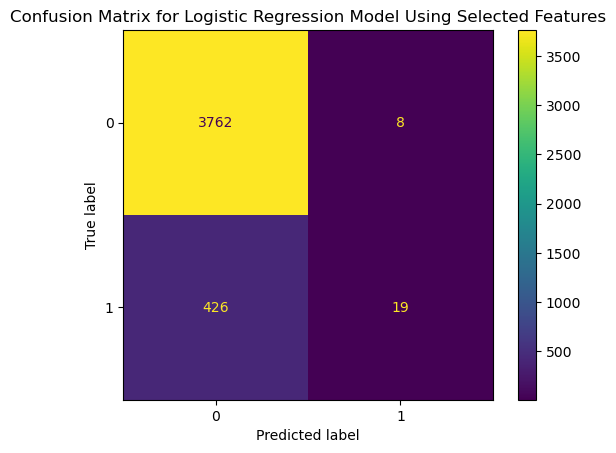

In [64]:
# Plot a confusion matrix to view the portion of false negatives and false positives that the model predicted
plot_confusion_matrix(logit_base_selected_2, X_test_selected_2, y_test)
plt.title('Confusion Matrix for Logistic Regression Model Using Selected Features')
plt.show()

Lastly, the selected features' coefficients all have a high predictive power for the negative class that does not involve cyclists instead of for the postive class. Surprisingly, none of the features which belong to the group of features storing the environmental condition in the dataset has a coefficient larger than 1. Thus, this suggests that there may be other features which are unique to each location where the features in the environmental conditions group failed to capture. For instance, additional features such as the volume of traffic, number of lanes, presence of bike lanes, presence of constructions, size of the pavements, etc. 

In [65]:
# View the model's coefficients by combining the list of feature names and coefficients into a dataframe object
d = {'Feature_Name': selected_features_2, 'Coefficient': logit_base_selected_2.coef_[0]}
logit_selected_coef_2 = pd.DataFrame(data=d)
# Sort the strength of the coefficients in descending order
logit_selected_coef_2.sort_values(by='Coefficient', ascending=False)

,Feature_Name,Coefficient
0,loc_Bay Street Corridor (76),1.142387
2,loc_West Humber-Clairville (1),-1.391765
7,inv_passenger,-1.537131
8,cau_speeding,-2.029491
1,loc_Rouge (131),-2.046234
4,loc_don valley,-2.207436
3,loc_gardiner,-2.581750
6,inv_pedestrian,-4.464811
5,inv_num,-4.894507


In the next section, different levels and types of regularization will be applied to the logistic regression model as an attempt to explore how enhancing or reducing the impacts of the features' weights as calculated by the coefficients can change the model's accuracies.   

### 4.3 Tuning Hyperparameters <a class= "anchor" id="p4.3"></a>

In this part, various versions of the logistic regression model which have different hyperparameters setting will be created to compare and contrast how changing the type of solver and level of regularization affect the model's performance. The logistic regression classifier has 5 different types of solver: "liblinear", "lbfgs", "newton-cg", "sag", and "saga". Each solver uses a different cost function to estimate how badly the machine learning model is performing when estimating the relationship between the input features and the predicted outcome. In addition, the solvers also use differing regularization penalties. There are two types of regularization penalties: Rigdge (L2) and Lasso (L1) regularization regression. The Rige (L2) penalty reduce the impacts of features with a large coefficients on the model's predicted outcomes in order to reduce overfitting. On the other hand, the Lasso (L1) penalty shrinks the less important features' coefficients and remove them to achieve a more robust model. 

A Cross Validation Grid Search method will be used to find the optimal level of regularization for the model. This method can run and record various logistic regression models with different settings for the penalities, types of solver, and level of regularization. The model's performances will be scored by using a five fold cross validation method which randomly split the training dataset into training and validating datasets each time the model is trained and tested for five times. The validation dataset will serve as a testing dataset for the trained model to evaluate its performance. By using the cross validation method, data leakage from the testing dataset can be avoided and the machine learning model is not overfitting to the dataset that it was trained and tested with. 

The grid search below will use the scaled training dataset including all features to find the optimal model. Since the regularization penalties take the impacts of each feature's weights into account, the model can automatically exclude irrelevant features. 

In [66]:
# Create a dictionary to set variations hyperparameter settings for the logistic models 
logit_param_grid = [  
    # Create models with various solvers and different level of L2 Ridge regularization
            {'C': [.001, .01, .1, 1, 10, 100, 1000],
             'penalty': ['l2'],
             'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
             'max_iter':[10000]},
    # Create models with solvers that accommodate the L1 Lasso regularization
            {'C': [.001, .01, .1, 1, 10, 100, 1000],
             'penalty':['l1'],
             'solver':['liblinear', 'saga'],
             'max_iter':[10000]}
]

# Instantiate a logistic regression model 
logit = LogisticRegression()

# Instantiate the grid then apply the pipeline and grid parameters to the grid and set the cross validation fold to 5
logit_grid = GridSearchCV(logit, logit_param_grid, cv=5, verbose=4)

# Fit the grid to the training dataset 
logit_fittedgrid = logit_grid.fit(X_train_scaled, y_train)

# Store the results from the grid as a pandas dataframe 
results_logit_op = pd.DataFrame(logit_fittedgrid.cv_results_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END C=0.001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.895 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.894 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.894 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.894 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.894 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.895 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.894 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.894 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.894 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=10000, penalty=l2, solver=n

[CV 3/5] END C=10, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.914 total time=   0.1s
[CV 4/5] END C=10, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.911 total time=   0.2s
[CV 5/5] END C=10, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.922 total time=   0.2s
[CV 1/5] END C=10, max_iter=10000, penalty=l2, solver=sag;, score=0.909 total time=   0.2s
[CV 2/5] END C=10, max_iter=10000, penalty=l2, solver=sag;, score=0.929 total time=   0.3s
[CV 3/5] END C=10, max_iter=10000, penalty=l2, solver=sag;, score=0.914 total time=   0.2s
[CV 4/5] END C=10, max_iter=10000, penalty=l2, solver=sag;, score=0.911 total time=   0.2s
[CV 5/5] END C=10, max_iter=10000, penalty=l2, solver=sag;, score=0.922 total time=   0.3s
[CV 1/5] END C=10, max_iter=10000, penalty=l2, solver=saga;, score=0.909 total time=   0.6s
[CV 2/5] END C=10, max_iter=10000, penalty=l2, solver=saga;, score=0.929 total time=   0.6s
[CV 3/5] END C=10, max_iter=10000, penalty=l2, solver=saga;, score=0.9

[CV 5/5] END C=1, max_iter=10000, penalty=l1, solver=liblinear;, score=0.922 total time=   0.1s
[CV 1/5] END C=1, max_iter=10000, penalty=l1, solver=saga;, score=0.911 total time=   0.6s
[CV 2/5] END C=1, max_iter=10000, penalty=l1, solver=saga;, score=0.928 total time=   0.5s
[CV 3/5] END C=1, max_iter=10000, penalty=l1, solver=saga;, score=0.913 total time=   0.5s
[CV 4/5] END C=1, max_iter=10000, penalty=l1, solver=saga;, score=0.913 total time=   0.6s
[CV 5/5] END C=1, max_iter=10000, penalty=l1, solver=saga;, score=0.922 total time=   0.6s
[CV 1/5] END C=10, max_iter=10000, penalty=l1, solver=liblinear;, score=0.909 total time=   0.1s
[CV 2/5] END C=10, max_iter=10000, penalty=l1, solver=liblinear;, score=0.928 total time=   0.0s
[CV 3/5] END C=10, max_iter=10000, penalty=l1, solver=liblinear;, score=0.914 total time=   0.0s
[CV 4/5] END C=10, max_iter=10000, penalty=l1, solver=liblinear;, score=0.911 total time=   0.1s
[CV 5/5] END C=10, max_iter=10000, penalty=l1, solver=libline

The results from the grid search method suggests that the model with the best performance uses the 'liblinear' solver with a L1 Lasso regularization penalty with a level of regularization of 0.1 as indicated by the C value. While changing the type of penalty and the level of regularization have some impacts on the model's cross validation score, the type of solver used for the model appears to have minimal impacts on the scores. 

In [67]:
# Find the best logistic regression model from the grid search
logit_fittedgrid.best_estimator_

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

The line graph below shows how changing the level of regularization affects the model's performance for models using a L1 and L2 penalty. The level of regularization is represented by the C value where the higher the C value is, the lower the level of regularization. As shown below, the models' performances peaked when the regularization level is set at a value of C equals 0.1. Moreover, the models do not perform well when the level of regularization is high as indicated by the C values lower than 0.1. While the L2 penalty leads to higher model's performance when the level of regularization is high, the L1 penalty increases the model's performance with a moderate to lower level of regularization. As the level of regularization decreases when the C value increases, both types of penalty no longer have any affect on the model's performance as shown by the plateau in the graph.   

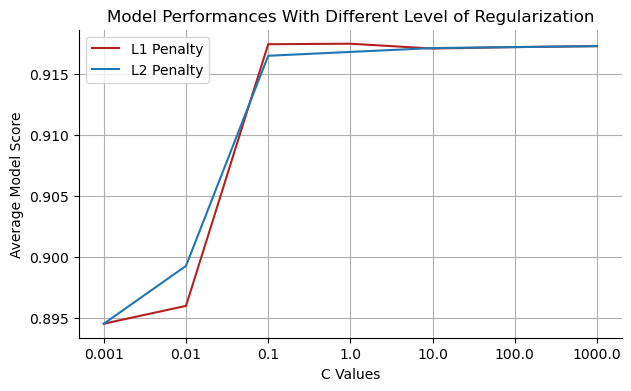

In [68]:
# Plot a graph to compare models with a L1 penalty against models with a L2 penalty 
# Group the results by the C values and calculate the average scores 
c_score = pd.DataFrame(results_logit_op.groupby(['param_penalty', 'param_C'])['mean_test_score'].mean())
plt.figure(figsize=(7,4))
plt.plot(c_score.index.get_level_values(1).unique().values.astype(str), c_score.loc['l1']['mean_test_score'].values, color='firebrick', label='L1 Penalty')
plt.plot(c_score.index.get_level_values(1).unique().values.astype(str), c_score.loc['l2']['mean_test_score'].values, label='L2 Penalty')
plt.title('Model Performances With Different Level of Regularization')
plt.xlabel('C Values')
plt.ylabel('Average Model Score')
plt.xticks(c_score.index.get_level_values(1).unique().values.astype(str))
plt.grid()
plt.legend()
sns.despine()
plt.show()

Thereby, the results obtained from the grid search method suggests that the model's performance may be improved by using the L1 Penalty with a regularization level of 0.1 to remove the effects of irrelevant features to some degree. However, the L1 penalty's relevant features' weights enhancement performs poorly when the enhancement is too strong which can potentially lead to the model overfitting to the training data.  

In [69]:
# Score the model with an optimal hyperparameter by using the testing dataset 
# Use the score model function 
logit_op_results = score_model(logit_fittedgrid.best_estimator_, 'logit_L1' ,X_train_scaled, y_train, X_test_scaled, y_test)

Compared to the baseline model which uses the L2 penalty, the logistic regression model which uses the L1 penalty performs slightly better in term of precision. As shown by the two models' precision scores below, the model with the L1 penalty achieved a score of 0.69 which is 0.04 points higher than the baseline model. 

In [70]:
# Compare the performance of the model using the L1 penalty to the baseline model 
pd.concat([logit_base_results, logit_op_results], axis=1)

,logit_base Model,logit_L1 Model
Train Score,0.9189,0.9193
Test Score,0.9155,0.9189
Precision,0.6519,0.6988
Recall,0.4292,0.4067
F1,0.5176,0.5142


Overall, the logistic regression models suggest that the features which contain the involvers and the accidents' locations information are highly relevant to distinguish between accidents that involve cyclists and other types of traffic accidents. Especially, locations play an important role in predicting the chances of a traffic accident involve cyclists. Thus, adding more information about different locations in the city may help to improve the model's ability to identify the leading causes in accidents that involve cyclists based on locational information. On the other hand, the trends in seasonality and timing of accidents are not clear for accidents that involve cyclists as the logistic regression model assign a low weight to features that provide time and date information.  

## 5. Non-Linear Machine Learning Models <a class= "anchor" id="p5"></a>

In this part, non-linear machine learning models will be used to further explore non-linear relationships between the variables that the linear logistic regression model cannot identify. The Non-linear support vector machines classifier, K-nearest neighbours classifier, and decision tree classifier will be created below. 

### 5.1 Non-Linear Support Vector Machines Classifier  <a class= "anchor" id="p5.1"></a>

Similar to the logistic regression classifier, the support vector machines classifier can learn linear decision boundaries. This model identify the boundaries by finding the middle point between the two classes. However, the support vector machines model is also able to learn non-linear boundaries as well by applying the kernel trick. Since the support vector machines model is sensitive to scaling, the scaled datasets will be used to training and testing the model. 

#### Baseline Non-linear SVM Model

The non-linear support vector machines model below is created by only using the default settings for the hyperparameters. The default hyperparameter settings are listed as follow: 
- The regularization parameter (C) is set at 1.0 by default.
- A 'rbf' kernel will be applied to the model. 
- The default kernel coefficient (gamma) for the default 'rbf' kernel is 'scale' 
- The probability estimate is disabled by default.
- The shrinking heuristic is enabled. 
- No maximum iteration is set for the model. 

More information regarding the SVM non-linear model can be accessed at [this link](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [71]:
# Create and fit the baseline svm model without any hyperparameters
svc = SVC()
svc_base = svc.fit(X_train_scaled, y_train)

In [72]:
# Score the model by using the score model function 
svc_base_results = score_model(svc_base, 'SVM_base', X_train_scaled, y_train, X_test_scaled, y_test)

In [73]:
# View the non-linear SVM model's performance
svc_base_results
# The model has a higher precision than the linear SVM model which was achieved by predicting fewer positive class

,SVM_base Model
Train Score,0.9404
Test Score,0.9265
Precision,0.7419
Recall,0.4652
F1,0.5718


The SVM model's train score of 0.94 is higher than the model's test score of 0.92 which suggests that this model is overfitting to the training data. In term of precision, the SVM model performed better than the previous logistic regression model since it was able to make a higher number of predictions for accidents that involve cyclists and 74.2% of them are accurate. Especially, the model also achieved a high F1 harmonic score of 0.57. 

#### Tuning Hyperparameters

Since the baseline model shows sign of being overfit to the training data, the model's hyperparameters will be tuned below by using the grid search and cross validation method as an attempt to reduce the overfitting. The models' kernel, regularization level, kernel coefficient (gamma), and shrinking heuristic will be altered as an attempt to find a model with a better performance.  

In [74]:
# Create a dictionary to set variations hyperparameter settings for the svm models 
svc_param_grid = [  
            {'kernel': ['poly', 'rbf', 'sigmoid'],
             'C':[.001, .01, .1, 1, 10, 100, 1000],
             'gamma':['scale', 'auto'],
             'shrinking':[True, False]}
]

# Instantiate a non-linear SVM model 
svc = SVC()

# Instantiate the grid then apply the pipeline and grid parameters to the grid and set the cross validation fold to 5
svc_grid = GridSearchCV(svc, svc_param_grid, cv=5, verbose=3)

# Fit the grid to the training dataset 
svc_fittedgrid = svc_grid.fit(X_train_scaled, y_train)

# Store the results from the grid as a pandas dataframe 
results_svc_op = pd.DataFrame(svc_fittedgrid.cv_results_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END C=0.001, gamma=scale, kernel=poly, shrinking=True;, score=0.895 total time=   1.7s
[CV 2/5] END C=0.001, gamma=scale, kernel=poly, shrinking=True;, score=0.894 total time=   1.7s
[CV 3/5] END C=0.001, gamma=scale, kernel=poly, shrinking=True;, score=0.894 total time=   1.7s
[CV 4/5] END C=0.001, gamma=scale, kernel=poly, shrinking=True;, score=0.894 total time=   1.6s
[CV 5/5] END C=0.001, gamma=scale, kernel=poly, shrinking=True;, score=0.894 total time=   1.6s
[CV 1/5] END C=0.001, gamma=scale, kernel=poly, shrinking=False;, score=0.895 total time=   1.6s
[CV 2/5] END C=0.001, gamma=scale, kernel=poly, shrinking=False;, score=0.894 total time=   1.7s
[CV 3/5] END C=0.001, gamma=scale, kernel=poly, shrinking=False;, score=0.894 total time=   1.7s
[CV 4/5] END C=0.001, gamma=scale, kernel=poly, shrinking=False;, score=0.894 total time=   1.8s
[CV 5/5] END C=0.001, gamma=scale, kernel=poly, shrinking=False;, scor

[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.895 total time=   2.1s
[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.894 total time=   2.1s
[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.894 total time=   2.1s
[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.894 total time=   1.9s
[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.894 total time=   1.8s
[CV 1/5] END C=0.01, gamma=auto, kernel=poly, shrinking=True;, score=0.895 total time=   1.3s
[CV 2/5] END C=0.01, gamma=auto, kernel=poly, shrinking=True;, score=0.894 total time=   1.3s
[CV 3/5] END C=0.01, gamma=auto, kernel=poly, shrinking=True;, score=0.894 total time=   1.2s
[CV 4/5] END C=0.01, gamma=auto, kernel=poly, shrinking=True;, score=0.894 total time=   1.1s
[CV 5/5] END C=0.01, gamma=auto, kernel=poly, shrinking=True;, score=0.894 total time=   1.1s
[CV 1/5] END C=0.01, gamma=auto, ke

[CV 3/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.894 total time=   1.6s
[CV 4/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.894 total time=   2.4s
[CV 5/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.894 total time=   2.8s
[CV 1/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.895 total time=   2.2s
[CV 2/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.894 total time=   2.1s
[CV 3/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.894 total time=   1.8s
[CV 4/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.894 total time=   2.2s
[CV 5/5] END C=0.1, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.894 total time=   1.9s
[CV 1/5] END C=1, gamma=scale, kernel=poly, shrinking=True;, score=0.924 total time=   1.7s
[CV 2/5] END C=1, gamma=scale, kernel=poly, shrinking=True;, score=0.936 total time=   1.7s
[CV 3/5] END C=1, gamma=scale, kernel=poly,

[CV 1/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=True;, score=0.856 total time=   2.6s
[CV 2/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=True;, score=0.852 total time=   2.5s
[CV 3/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=True;, score=0.858 total time=   3.0s
[CV 4/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=True;, score=0.854 total time=   3.1s
[CV 5/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=True;, score=0.880 total time=   1.5s
[CV 1/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.857 total time=   2.4s
[CV 2/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.853 total time=   2.2s
[CV 3/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.858 total time=   2.0s
[CV 4/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.854 total time=   1.8s
[CV 5/5] END C=10, gamma=scale, kernel=sigmoid, shrinking=False;, score=0.880 total time=   1.4s
[CV 1/5] END C=10, gamma=auto, kern

[CV 3/5] END C=100, gamma=auto, kernel=rbf, shrinking=False;, score=0.935 total time=   7.5s
[CV 4/5] END C=100, gamma=auto, kernel=rbf, shrinking=False;, score=0.927 total time=   7.3s
[CV 5/5] END C=100, gamma=auto, kernel=rbf, shrinking=False;, score=0.928 total time=  10.0s
[CV 1/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.890 total time=   3.8s
[CV 2/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.896 total time=   3.2s
[CV 3/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.893 total time=   3.3s
[CV 4/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.889 total time=   2.4s
[CV 5/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=True;, score=0.900 total time=   2.6s
[CV 1/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.890 total time=   3.3s
[CV 2/5] END C=100, gamma=auto, kernel=sigmoid, shrinking=False;, score=0.898 total time=   4.5s
[CV 3/5] END C=100, gamma=auto, kernel=sigmoid,

The best model resulted from the grid search method uses a default have a low regularization level of 10 as shown below. As for other hyperparameters, this model uses the default settings for the kernel, gamma, and an enabled shrinking heuristic. 

In [75]:
# View the best model's parameters resulted from the grid search method
svc_fittedgrid.best_estimator_

SVC(C=10)

Furthermore, the line graph below explores how the performances of each model with different kernel change when the level of regularization changes.  

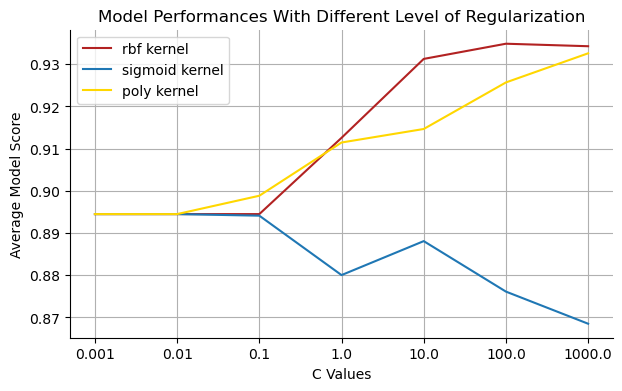

In [76]:
# Plot a graph to compare the performance of models using differing kernels 
# Group the results by the C values and calculate the average scores 
c_score = pd.DataFrame(results_svc_op.groupby(['param_kernel', 'param_C'])['mean_test_score'].mean())
plt.figure(figsize=(7,4))
plt.plot(c_score.index.get_level_values(1).unique().values.astype(str), c_score.loc['rbf']['mean_test_score'].values, color='firebrick', label='rbf kernel')
plt.plot(c_score.index.get_level_values(1).unique().values.astype(str), c_score.loc['sigmoid']['mean_test_score'].values, label='sigmoid kernel')
plt.plot(c_score.index.get_level_values(1).unique().values.astype(str), c_score.loc['poly']['mean_test_score'].values, label='poly kernel', color='gold')
plt.title('Model Performances With Different Level of Regularization')
plt.xlabel('C Values')
plt.ylabel('Average Model Score')
plt.xticks(c_score.index.get_level_values(1).unique().values.astype(str))
plt.grid()
plt.legend()
sns.despine()
plt.show() 

When the level of regularization by using the L2 penalty is high, all models from the three kernels: rbg, sigmoid, and poly perform similarly. However, as the level of regularization decreases which is shown by the increasing C values, the models with the rbf and poly kernel performance increases while the sigmoid kernel's performances declines. Out of the three kernels, the rbf kernel has the highest score which indicate that it was able to establish more accurate boundaries between the accidents that involve cyclists and other types of traffic accidents. 

In [77]:
# Score the model by using the score model function 
svc_op_results = score_model(svc_fittedgrid.best_estimator_, 'SVM_hyperparameter',X_train_scaled, y_train, X_test_scaled, y_test)

In [78]:
# View the model's scores compared to the baseline model
pd.concat([svc_base_results,svc_op_results], axis=1)

,SVM_base Model,SVM_hyperparameter Model
Train Score,0.9404,0.9877
Test Score,0.9265,0.9447
Precision,0.7419,0.7573
Recall,0.4652,0.7011
F1,0.5718,0.7281


As shown by the scoring table above which compare the baseline SVM model to the SVM model with a lower level of regularization, the model with a lower regularization performs slightly better. Although the model with the tuned hyperparameters still show signs of being overfitted to the training data, its precision, recall and F1 harmony score increase significantly. Thus, this resulting performance suggests that by lowering the level of regularization which allow the model to enhance the weight of relevant features, the SVM model becomes better at identifying the non-linear trends found in the dataset. However, the SVM model is not as easy to interpret as the logistic regression model so the non-linear trends that the model identified cannot be explicitly explained by viewing the feature coefficients. 

### 5.2 K-Nearest Neighbours Classifier <a class= "anchor" id="p5.2"></a>

The K-Nearest Neighbours classifier set the boundaries between the different classes in the data by finding the distances between the data points and grouping them according to their distances. The underlying assumption that the K-Nearest Neighbours classifier has is that data points coming from the same class should be close to each other in term of distances. Due to the model's sensitivity to scaling, the scaled dataset will be used to train and test the model. 

#### Baseline KNN Model

Firstly, to find the K-Nearest Neighbours model's initial performance when being introduced to the traffic data, a baseline model will be created. This model will use the default settings for the hyperparameters as listed below: 
- The default size of the nearest neighbour is set at 5. 
- An 'auto' algorithm is applied to compute the nearest neighbours. 
- The default metric used to calculate the distance between the data points is the Euclidean distance.

More information regarding the KNN model and its hyperparameters can be accessed at [this link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [79]:
# Create and fit the baseline knn model without any hyperparameters
knn = KNeighborsClassifier()
knn_base = knn.fit(X_train_scaled, y_train)

In [80]:
# Score the model by using the score model function 
knn_base_results = score_model(knn_base, 'KNN_base' ,X_train_scaled, y_train, X_test_scaled, y_test)

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [81]:
# View the model's scores
knn_base_results

,KNN_base Model
Train Score,0.9495
Test Score,0.9227
Precision,0.6977
Recall,0.4719
F1,0.5630


The KNN baseline model's scores suggest that the model is also overfitting the data like the SVM model did previously. Moreover, the model's precision and F1 harmony scores are higher than that of the logistic regression model which suggests that there are certain traits that are unique to traffic accidents which involve cyclists that can be identify by using the closeness in distances between the data points.  

#### Tuning Hyperparameters

The grid search method below is used to find hyperparameters that can improve the KNN model's performance. The hyperparameters which are altered in the KNN model are: the number of neighbours, how the weight of the features are calculated, and the type of metric used to calculate the distance between the data points. 

In [82]:
# Create a dictionary to set variations hyperparameter settings for the knn models 
knn_param_grid = [  
            {'n_neighbors': [5,10,15,20,25,30],
             'weights': ['uniform', 'distance'],
             'p':[1,2]}
]

# Instantiate a logistic regression model 
knn = KNeighborsClassifier()

# Instantiate the grid then apply the pipeline and grid parameters to the grid and set the cross validation fold to 5
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5)

# Fit the grid to the training dataset 
knn_fittedgrid = knn_grid.fit(X_train_scaled, y_train)

# Store the results from the grid as a pandas dataframe 
results_knn_op = pd.DataFrame(knn_fittedgrid.cv_results_)

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\nghip\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

The grid search method suggests that KNN model perform better when a distance weight function is used. Unlike the default uniform weight function, the distance weight function assign greater influence to closer neighbours of a query point than the neighbours that are further away. On the other hand, the default uniform weight function weighted all points in the neighbourhood equally. Thereby, this suggests that differences between the accidents that involve cyclists and other types of traffic accidents may be too similar for the model to find boundaries by using a uniform weight. 

In addition, the best estimator also uses a Manhattan distance instead of the default Euclidean distance. The Manhattan distance measures the distance between two points by measuring along the axes at right angles.  

In [83]:
# View the optimal parameters 
knn_fittedgrid.best_estimator_
# The optimal number of neighbors is 5, using a 'distance' weight method, and form clusters by using a Manhattan distance 

KNeighborsClassifier(p=1, weights='distance')

The line graph below explores how the KNN models with different weight functions perform when the number of neighbours change. 

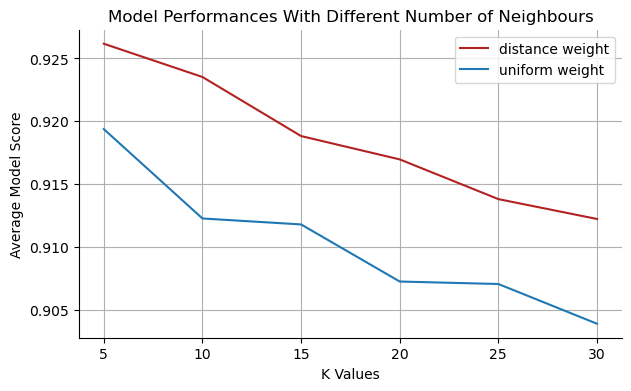

In [84]:
k_score = pd.DataFrame(results_knn_op.groupby(['param_weights', 'param_n_neighbors'])['mean_test_score'].mean())
plt.figure(figsize=(7,4))
plt.plot(k_score.index.get_level_values(1).unique().values.astype(str), k_score.loc['distance']['mean_test_score'].values, color='firebrick', label='distance weight')
plt.plot(k_score.index.get_level_values(1).unique().values.astype(str), k_score.loc['uniform']['mean_test_score'].values, label='uniform weight')
plt.title('Model Performances With Different Number of Neighbours')
plt.xlabel('K Values')
plt.ylabel('Average Model Score')
plt.xticks(k_score.index.get_level_values(1).unique().values.astype(str))
plt.grid()
plt.legend()
sns.despine()
plt.show()

The graph shows that as the number of neighbours required for boundaries to be drawn increase, the model's performance decreases. Thus, this may suggests that the traffic accidents that involve cyclists may have diverse characteristics which are unique to each cases that prevent them from forming a large group with data points close to each other. Thereby, when the KNN model group the data points together based on the size of the group and the distances between each member of the group, the model failed to accurately group all instances of accidents that involve cyclist together in one big group with a large number of members. 

In [85]:
# Score the model by using the score model function 
knn_op_results = score_model(knn_fittedgrid.best_estimator_, 'KNN_hyperparameters',X_train_scaled, y_train, X_test_scaled, y_test)

In [86]:
# Compare the baseline model's results to the results of the KNN model with the tuned hyperparameters
pd.concat([knn_base_results, knn_op_results], axis=1)

,KNN_base Model,KNN_hyperparameters Model
Train Score,0.9495,1.0000
Test Score,0.9227,0.9364
Precision,0.6977,0.7674
Recall,0.4719,0.5708
F1,0.5630,0.6546


Overall, the KNN model's performances increase after the hyperparameters are tuned. However, the model still shows sign of being overfitted to the training dataset. Evidently, the KNN model with the tuned hyperparameters managed to achieve a perfect training score of 1.0 while its testing score is only 0.94. As for the model's level of precision, the model with the hyperparameter gained a higher precision score of 0.76. However, the higher precision score might be due to the higher number of positive class labels that the model predict by using a different distance metric and weight distribution method. Therefore, the KNN model's performances suggest that the dataset need more features that are unique to the accidents which involve cyclists that the current dataset failed to provide to be able to form a larger group of the positive class with a higher number of neighbours. If a KNN model can achive a high test score and a high precision score with a higher number of neighbours set in the hyperparameter, this may be a good indication that the instances of accidents involving cyclists have distinctive characteristics that set them apart from other types of traffic accidents.  

### 5.3 Decision Tree Classifier <a class= "anchor" id="p5.3"></a>

The decision tree classifier is supervised machine learning algorithm that can learn non-linear decision boundaries. Different from the K-Nearest Neighbours classifier, the decision tree model is not distance-based. The decision tree model works by combining binary classifiers together to group data based on their labels. Thus, the dataset which is not scaled will be used to train the decision tree model.  

#### Baseline Decision Tree Model

Firstly, a baseline decision tree model which uses a default hyperparameter settings will be used to get a general idea of the model's performance. Below is a list of hyperparameters and their default settings for the baseline model:
- The default function used to measure the quality of a split is Gini impurity. 
- The best splitter strategy is applied by default to choose the split at each node. 
- The default minimum required sample to split an internal node is set at 2 samples. 
- The default minimum number of samples required to be at a leaf node is set at 1 sample.
- Other hyperparameters such as maximum tree depth, minimum weighted fraction, maximum features, random state, etc. all have a default setting of 'None'. 

More information regarding the decision tree classifier can be accessed on [this link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [87]:
# The code in this cell will create a Decision Tree model with a default settings for the hyperparameters
# Instantiate the Decision Tree model
dt = DecisionTreeClassifier()
# Fit the training data to the model 
dt_base = dt.fit(X_train, y_train)

In [88]:
# Score the model by using the score model function 
dt_base_results = score_model(dt_base, 'DT_base',X_train, y_train, X_test, y_test)

In [89]:
# View the scores of the decision tree baseline model
dt_base_results

,DT_base Model
Train Score,1.0000
Test Score,0.9699
Precision,0.8647
Recall,0.8472
F1,0.8558


Compared to other non-linear models, the decision tree classifier's performance is significantly better. The model managed to gain a high precision, recall, and F1 harmony score of 0.84. However, a major concern that this model have is it's overfitting to the training dataset as shown by its perfect train score of 1.0. 

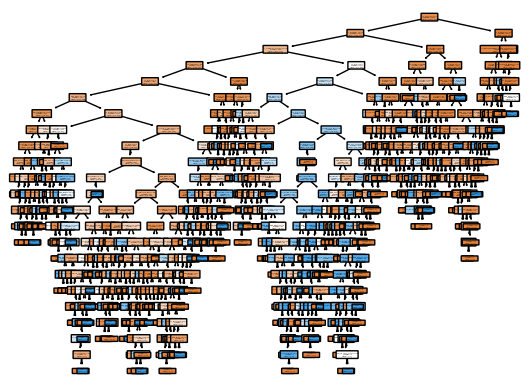

In [90]:
# Import the plot_tree function from sk-learn
from sklearn import tree
# Identify the target names 
target_names = ['Involve Cylists', 'Others']
# Plot the decision tree model's nodes and splits 
tree.plot_tree(dt_base, 
          feature_names= features, 
          class_names = target_names,
          rounded=True,
          impurity=False,
          filled=True)

plt.show()

The tree plot above displays the decisions that the tree made when splitting the nodes to classify the accidents that involve cyclists and other types of accidents. The abundant number of nodes and splits suggests that the model was overfitted to the data by having too many nodes and splitting too many times. 

In addition, to explore the importance of each features in splitting the nodes in the baseline decision tree model, the mean decrease in impurity (MDI) is calculated below for each input feature. 

In [91]:
# Use the compute feature importances function from the Scikit-Learn package to calculate each feature's level of importance 
# Create a dataframe to store the calculated values
importances_df = pd.DataFrame({'Variable': features,
                               'Importance': dt_base.tree_.compute_feature_importances(normalize=False)})

# Sort the variables in the dataframe by their MDI score in descending order
importances_df.sort_values(by='Importance', ascending=False)

,Variable,Importance
13,loc_latitude,0.025381
45,inv_passenger,0.019325
14,loc_longitude,0.016458
0,inv_num,0.015156
43,inv_pedestrian,0.013809
17,loc_Toronto and East York,0.012430
3,date_month,0.011905
1,date_year,0.011726
52,cau_speeding,0.006424
7,date_Thursday,0.003882


The top three most important features are: the latitude, passenger involvement, and longitude. Different from the logistic regression model, the decision tree seems to be able to identify trends in the locational details based on the latitude and longitude. Especially, the decision tree places less importance on the dummy variables that identify the district, street, and neighbourhood where the accident happened. This suggests that the decision tree model maybe able to combine the findings from both latitude, longitude, and other features describing the involver, human factors, and environmental factors to make better predictions than the logistic regression did. 

In the part below, a bagging technique will be applied to prevent the model from being overfitted to the training data. 

#### Random Forest

In order to generalize the decision tree model and prevent it from overfitting to the training data, the random forest classifier will be used to randomly fit several deep decision trees with a different subset of the dataset. These trees are trained parallel to each other and they are independent from each other. The variations in predicted class labels which arise from each decision tree can be balanced out by other decision trees. In other word, while some trees may make the wrong predictions, many other trees will make the right predictions. Thus, as a group, the trees will move in the right direction. 

The number of decision trees, maximum depth and minimum samples leaf for each tree in the random forest model can be set manually to control the model's degree of generalization. In the cell below, a grid search method will be applied to the decision tree model in order to find the random forest model with the best performance. More information regarding the random forest classifier's hyperparameters can be accessed through [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [92]:
# Import the random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a dictionary to set variations hyperparameter settings for the knn models 
rf_param_grid = [  
            {'n_estimators': [100,200,300,400,500],
             'max_depth': [2,3,4,5,6,7,8],
             'min_samples_leaf':[5,10,15,20]}
]

# Instantiate the random forest classifier 
rf = RandomForestClassifier()

# Instantiate the grid then apply the pipeline and grid parameters to the grid and set the cross validation fold to 5
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, verbose=3)

# Fit the grid to the training dataset 
rf_fittedgrid = rf_grid.fit(X_train, y_train)

# Store the results from the grid as a pandas dataframe 
results_rf_op = pd.DataFrame(rf_fittedgrid.cv_results_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV 1/5] END max_depth=2, min_samples_leaf=5, n_estimators=100;, score=0.895 total time=   0.4s
[CV 2/5] END max_depth=2, min_samples_leaf=5, n_estimators=100;, score=0.894 total time=   0.3s
[CV 3/5] END max_depth=2, min_samples_leaf=5, n_estimators=100;, score=0.894 total time=   0.3s
[CV 4/5] END max_depth=2, min_samples_leaf=5, n_estimators=100;, score=0.894 total time=   0.3s
[CV 5/5] END max_depth=2, min_samples_leaf=5, n_estimators=100;, score=0.894 total time=   0.3s
[CV 1/5] END max_depth=2, min_samples_leaf=5, n_estimators=200;, score=0.895 total time=   0.7s
[CV 2/5] END max_depth=2, min_samples_leaf=5, n_estimators=200;, score=0.894 total time=   0.8s
[CV 3/5] END max_depth=2, min_samples_leaf=5, n_estimators=200;, score=0.894 total time=   0.8s
[CV 4/5] END max_depth=2, min_samples_leaf=5, n_estimators=200;, score=0.894 total time=   0.7s
[CV 5/5] END max_depth=2, min_samples_leaf=5, n_estimators=200;, score=0.

[CV 1/5] END max_depth=2, min_samples_leaf=20, n_estimators=300;, score=0.895 total time=   1.1s
[CV 2/5] END max_depth=2, min_samples_leaf=20, n_estimators=300;, score=0.894 total time=   1.1s
[CV 3/5] END max_depth=2, min_samples_leaf=20, n_estimators=300;, score=0.894 total time=   1.1s
[CV 4/5] END max_depth=2, min_samples_leaf=20, n_estimators=300;, score=0.894 total time=   1.1s
[CV 5/5] END max_depth=2, min_samples_leaf=20, n_estimators=300;, score=0.894 total time=   1.2s
[CV 1/5] END max_depth=2, min_samples_leaf=20, n_estimators=400;, score=0.895 total time=   1.6s
[CV 2/5] END max_depth=2, min_samples_leaf=20, n_estimators=400;, score=0.894 total time=   1.7s
[CV 3/5] END max_depth=2, min_samples_leaf=20, n_estimators=400;, score=0.894 total time=   1.5s
[CV 4/5] END max_depth=2, min_samples_leaf=20, n_estimators=400;, score=0.894 total time=   1.5s
[CV 5/5] END max_depth=2, min_samples_leaf=20, n_estimators=400;, score=0.894 total time=   1.6s
[CV 1/5] END max_depth=2, min_

[CV 1/5] END max_depth=3, min_samples_leaf=15, n_estimators=500;, score=0.895 total time=   2.8s
[CV 2/5] END max_depth=3, min_samples_leaf=15, n_estimators=500;, score=0.894 total time=   2.6s
[CV 3/5] END max_depth=3, min_samples_leaf=15, n_estimators=500;, score=0.894 total time=   2.5s
[CV 4/5] END max_depth=3, min_samples_leaf=15, n_estimators=500;, score=0.894 total time=   3.1s
[CV 5/5] END max_depth=3, min_samples_leaf=15, n_estimators=500;, score=0.894 total time=   4.1s
[CV 1/5] END max_depth=3, min_samples_leaf=20, n_estimators=100;, score=0.895 total time=   0.7s
[CV 2/5] END max_depth=3, min_samples_leaf=20, n_estimators=100;, score=0.894 total time=   0.7s
[CV 3/5] END max_depth=3, min_samples_leaf=20, n_estimators=100;, score=0.894 total time=   0.5s
[CV 4/5] END max_depth=3, min_samples_leaf=20, n_estimators=100;, score=0.894 total time=   0.7s
[CV 5/5] END max_depth=3, min_samples_leaf=20, n_estimators=100;, score=0.894 total time=   0.6s
[CV 1/5] END max_depth=3, min_

[CV 1/5] END max_depth=4, min_samples_leaf=15, n_estimators=200;, score=0.895 total time=   1.4s
[CV 2/5] END max_depth=4, min_samples_leaf=15, n_estimators=200;, score=0.894 total time=   1.3s
[CV 3/5] END max_depth=4, min_samples_leaf=15, n_estimators=200;, score=0.894 total time=   1.1s
[CV 4/5] END max_depth=4, min_samples_leaf=15, n_estimators=200;, score=0.894 total time=   1.1s
[CV 5/5] END max_depth=4, min_samples_leaf=15, n_estimators=200;, score=0.894 total time=   1.1s
[CV 1/5] END max_depth=4, min_samples_leaf=15, n_estimators=300;, score=0.895 total time=   1.8s
[CV 2/5] END max_depth=4, min_samples_leaf=15, n_estimators=300;, score=0.894 total time=   1.7s
[CV 3/5] END max_depth=4, min_samples_leaf=15, n_estimators=300;, score=0.894 total time=   1.5s
[CV 4/5] END max_depth=4, min_samples_leaf=15, n_estimators=300;, score=0.894 total time=   1.5s
[CV 5/5] END max_depth=4, min_samples_leaf=15, n_estimators=300;, score=0.894 total time=   1.6s
[CV 1/5] END max_depth=4, min_

[CV 1/5] END max_depth=5, min_samples_leaf=10, n_estimators=400;, score=0.895 total time=   2.9s
[CV 2/5] END max_depth=5, min_samples_leaf=10, n_estimators=400;, score=0.894 total time=   2.7s
[CV 3/5] END max_depth=5, min_samples_leaf=10, n_estimators=400;, score=0.894 total time=   3.0s
[CV 4/5] END max_depth=5, min_samples_leaf=10, n_estimators=400;, score=0.894 total time=   3.0s
[CV 5/5] END max_depth=5, min_samples_leaf=10, n_estimators=400;, score=0.894 total time=   3.3s
[CV 1/5] END max_depth=5, min_samples_leaf=10, n_estimators=500;, score=0.895 total time=   4.7s
[CV 2/5] END max_depth=5, min_samples_leaf=10, n_estimators=500;, score=0.894 total time=   4.3s
[CV 3/5] END max_depth=5, min_samples_leaf=10, n_estimators=500;, score=0.894 total time=   5.1s
[CV 4/5] END max_depth=5, min_samples_leaf=10, n_estimators=500;, score=0.894 total time=   4.5s
[CV 5/5] END max_depth=5, min_samples_leaf=10, n_estimators=500;, score=0.894 total time=   5.2s
[CV 1/5] END max_depth=5, min_

[CV 1/5] END max_depth=6, min_samples_leaf=10, n_estimators=100;, score=0.895 total time=   0.5s
[CV 2/5] END max_depth=6, min_samples_leaf=10, n_estimators=100;, score=0.894 total time=   0.6s
[CV 3/5] END max_depth=6, min_samples_leaf=10, n_estimators=100;, score=0.894 total time=   0.6s
[CV 4/5] END max_depth=6, min_samples_leaf=10, n_estimators=100;, score=0.894 total time=   0.5s
[CV 5/5] END max_depth=6, min_samples_leaf=10, n_estimators=100;, score=0.895 total time=   0.5s
[CV 1/5] END max_depth=6, min_samples_leaf=10, n_estimators=200;, score=0.895 total time=   1.2s
[CV 2/5] END max_depth=6, min_samples_leaf=10, n_estimators=200;, score=0.894 total time=   1.2s
[CV 3/5] END max_depth=6, min_samples_leaf=10, n_estimators=200;, score=0.894 total time=   1.3s
[CV 4/5] END max_depth=6, min_samples_leaf=10, n_estimators=200;, score=0.894 total time=   1.3s
[CV 5/5] END max_depth=6, min_samples_leaf=10, n_estimators=200;, score=0.894 total time=   1.2s
[CV 1/5] END max_depth=6, min_

[CV 1/5] END max_depth=7, min_samples_leaf=5, n_estimators=300;, score=0.898 total time=   2.2s
[CV 2/5] END max_depth=7, min_samples_leaf=5, n_estimators=300;, score=0.896 total time=   2.2s
[CV 3/5] END max_depth=7, min_samples_leaf=5, n_estimators=300;, score=0.895 total time=   2.1s
[CV 4/5] END max_depth=7, min_samples_leaf=5, n_estimators=300;, score=0.898 total time=   2.0s
[CV 5/5] END max_depth=7, min_samples_leaf=5, n_estimators=300;, score=0.894 total time=   2.1s
[CV 1/5] END max_depth=7, min_samples_leaf=5, n_estimators=400;, score=0.901 total time=   3.1s
[CV 2/5] END max_depth=7, min_samples_leaf=5, n_estimators=400;, score=0.896 total time=   2.8s
[CV 3/5] END max_depth=7, min_samples_leaf=5, n_estimators=400;, score=0.894 total time=   2.9s
[CV 4/5] END max_depth=7, min_samples_leaf=5, n_estimators=400;, score=0.896 total time=   2.7s
[CV 5/5] END max_depth=7, min_samples_leaf=5, n_estimators=400;, score=0.896 total time=   2.9s
[CV 1/5] END max_depth=7, min_samples_le

[CV 1/5] END max_depth=7, min_samples_leaf=20, n_estimators=500;, score=0.898 total time=   3.6s
[CV 2/5] END max_depth=7, min_samples_leaf=20, n_estimators=500;, score=0.896 total time=   3.6s
[CV 3/5] END max_depth=7, min_samples_leaf=20, n_estimators=500;, score=0.895 total time=   3.5s
[CV 4/5] END max_depth=7, min_samples_leaf=20, n_estimators=500;, score=0.895 total time=   3.9s
[CV 5/5] END max_depth=7, min_samples_leaf=20, n_estimators=500;, score=0.894 total time=   3.7s
[CV 1/5] END max_depth=8, min_samples_leaf=5, n_estimators=100;, score=0.904 total time=   0.6s
[CV 2/5] END max_depth=8, min_samples_leaf=5, n_estimators=100;, score=0.901 total time=   0.6s
[CV 3/5] END max_depth=8, min_samples_leaf=5, n_estimators=100;, score=0.901 total time=   0.7s
[CV 4/5] END max_depth=8, min_samples_leaf=5, n_estimators=100;, score=0.899 total time=   0.6s
[CV 5/5] END max_depth=8, min_samples_leaf=5, n_estimators=100;, score=0.899 total time=   0.7s
[CV 1/5] END max_depth=8, min_sampl

[CV 1/5] END max_depth=8, min_samples_leaf=20, n_estimators=200;, score=0.902 total time=   1.6s
[CV 2/5] END max_depth=8, min_samples_leaf=20, n_estimators=200;, score=0.900 total time=   1.6s
[CV 3/5] END max_depth=8, min_samples_leaf=20, n_estimators=200;, score=0.898 total time=   1.6s
[CV 4/5] END max_depth=8, min_samples_leaf=20, n_estimators=200;, score=0.900 total time=   1.5s
[CV 5/5] END max_depth=8, min_samples_leaf=20, n_estimators=200;, score=0.903 total time=   1.8s
[CV 1/5] END max_depth=8, min_samples_leaf=20, n_estimators=300;, score=0.901 total time=   2.2s
[CV 2/5] END max_depth=8, min_samples_leaf=20, n_estimators=300;, score=0.899 total time=   2.1s
[CV 3/5] END max_depth=8, min_samples_leaf=20, n_estimators=300;, score=0.897 total time=   2.0s
[CV 4/5] END max_depth=8, min_samples_leaf=20, n_estimators=300;, score=0.900 total time=   2.2s
[CV 5/5] END max_depth=8, min_samples_leaf=20, n_estimators=300;, score=0.899 total time=   2.0s
[CV 1/5] END max_depth=8, min_

The results gained from the grid search method for the random forest model suggests that the model always have the highest performance when the maximum tree depth have the highest setting within the range identified in the parameter grid. 

In [93]:
# View the parameters of the model with the best performance
rf_fittedgrid.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=5, n_estimators=300)

The table below calculates the permutation importances of the features in the model. Similar to the mean decrease in impurity function above, this function also calculates the degree of importance each feature has in the random forest model by randomly shuffle the columns in the dataset and find the score of the model based on the new dataset.  

In [94]:
# Import the Scikit-Learn function to calculate the random forest's features' importance 
from sklearn.inspection import permutation_importance

# Run the permutation_importance calculation for the randomly selected columns 
# Repeat the permutation step 100 times per column
result = permutation_importance(rf_fittedgrid.best_estimator_, X_test, y_test, n_repeats=100, random_state=0)

# Calculate the average importance for each feature
importances = result.importances_mean

# Normalize the importances
normalized_importances = importances / importances.sum()


# Create a dataframe to store the calculated values
permute_importances_df = pd.DataFrame({'Variable': features,
                               'Importance': importances,
                               'Normalized Importance': normalized_importances})

permute_importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

permute_importances_df

,Variable,Importance,Normalized Importance
0,inv_pedestrian,6.000000e-03,1.496184e-01
1,loc_Toronto and East York,3.710558e-03,9.252795e-02
2,loc_latitude,3.440095e-03,8.578359e-02
3,loc_longitude,2.761566e-03,6.886352e-02
4,inv_passenger,2.678529e-03,6.679288e-02
5,inv_num,2.631079e-03,6.560966e-02
6,cau_agressive_driv,2.139976e-03,5.336331e-02
7,cau_driving_properly,2.073547e-03,5.170680e-02
8,cau_going_ahead,1.814947e-03,4.525824e-02
9,date_winter,1.539739e-03,3.839555e-02


According to the permutation importance calculations above, this model top 4 most important features are: pedestrian involvement, Toronto and East York district, latitude and longitude. While the features storing the involver and locational information are the most important, features that store the date and time information are least important. Thereby, it is possible that the trend and seasonality found in the dataset may not be unique to accidents involving cyclists. Overall, these features' levels of importance are very similar to that of the baseline decision tree model. Especially, the calculated importance values are relatively low which suggests that there maybe a high level of overlapping between the accidents involving cyclists and other types of accidents which prevent the decision tree model to draw effective boundaries without overfitting to the details that the training dataset provided.  

In [95]:
# Score the model
rf_op_results = score_model(rf_fittedgrid.best_estimator_, 'random_forest',X_train, y_train, X_test, y_test)

In [96]:
# View the model's results compared to the baseline model's results
pd.concat([dt_base_results, rf_op_results], axis=1)

,DT_base Model,random_forest Model
Train Score,1.0000,0.9064
Test Score,0.9699,0.9004
Precision,0.8647,0.7273
Recall,0.8472,0.0899
F1,0.8558,0.1600


Overall, the random forest model is still overfitted to the training dataset as shown by its trains score being higher than its test score. Especially, this model has a very high precision score of 0.90 while predicting fewer number of the positive class than the decision tree model. 

## 6. Conclusion <a class= "anchor" id="p6"></a>

Overall, the linear regression models identified important features in the dataset which may help to distinguish accidents that are specific to cyclist from other types of traffic accidents. For instance, features which contain information regarding who was involved in the traffic accident is a strong indicator for accidents involving cyclists since cyclists are least likely to get involved in traffic accidents with pedestrians or passengers. In addition, locational information also have a high predictive power as several neighbourhoods are more dangerous to cyclists than other. On the other hand, the time and date features are not as predictive since they contain limited information which are unique to accidents that involve cyclists. 

Furthermore, the non-linear machine learning models also indicate that there are non-linear trends in the dataset. Compared to the logistic regression's performance, the non-linear models' precision and F1 harmony scores are higher. However, the k-nearest neighbours and decision tree classifier failure to group and classify the classes without overfitting to the training dataset implies that accidents involving cyclists are similar to other types of traffic accident. By using the provided information in the KSI dataset provided by the Toronto Police Services' Public Safety Data Portal alone is not sufficient to specify the dangers on the street which are unique to cyclists. For instance, locational features such as the presence of bike lanes, volume of traffic at certain time and locations, and the number of lanes a road have may help to gain a better understanding of the road designs which are dangerous for cyclists. 

In [97]:
# Compare the linear and non-linear model created in this notebook
results = pd.concat([logit_op_results,svc_op_results,knn_op_results, rf_op_results], axis=1)

cm = sns.light_palette("red", as_cmap=True)
results.style.background_gradient(axis=1, cmap=cm)

,logit_L1 Model,SVM_hyperparameter Model,KNN_hyperparameters Model,random_forest Model
Train Score,0.919300,0.987700,1.000000,0.906400
Test Score,0.918900,0.944700,0.936400,0.900400
Precision,0.698800,0.757300,0.767400,0.727300
Recall,0.406700,0.701100,0.570800,0.089900
F1,0.514200,0.728100,0.654600,0.160000


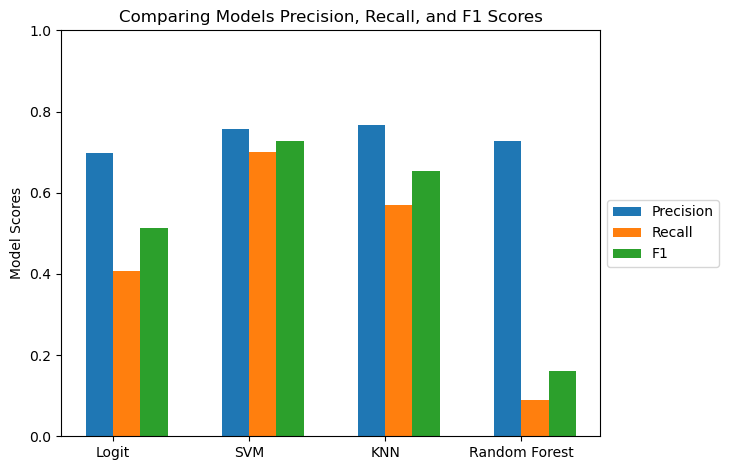

In [98]:
# Plot a bar chart to show the model's performances
# Identify the values for each columns
labels = ['Logit', 'SVM', 'KNN', 'Random Forest']
precision = list(results.loc['Precision'].values)
recall = list(results.loc['Recall'].values)
f1 = list(results.loc['F1'].values)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Create a plot with each group of columns
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')
rects3 = ax.bar(x + width*1.5, f1, width, label='F1')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Model Scores')
ax.set_title('Comparing Models Precision, Recall, and F1 Scores')
ax.set_xticks(x, labels)
plt.ylim(bottom=0, top=1)
ax.legend()

# Move the legend outside of the graph
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()

The table above summarizes scores of the best model for each classifier. Out of these four models, the non-linear SVM model have both a high precision and a high F1 harmony scores which indicate there might be clear boundaries presence between the accidents involving cyclists and other types of traffic accidents. Similarly, the k-nearest neighbours model also achieve a high level of precision by grouping the datapoints together based on their Manhattan distances.  

#### Next Steps 

The next steps for this project can be incorporate more locational attributes into the dataset to further study how the road designs can be used to predict where cyclists are more likely to get into traffic accidents. The models can also be trained again by using an updated Toronto traffic accident dataset to capture emerging trends or improvements in road safeties. Last but not least, the outputs from the machine learning models created in this project can be incorporated into GPS or mapping applications to help cyclists avoid potentially dangerous streets, congestions, and situations when it may not be safe to ride bikes.  